In [1]:
import numpy as np
import qmt
import imt
import ring
from imt.utils.view import view
from imt.utils.view import VisOptions
import matplotlib.pyplot as plt
import tree
import pandas as pd

In [19]:
# LOAD DATA
file = "C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/IMU/Dict_Frames/S0133_dict_frame.npy"  # noqa: E501
file_camera2d = "C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/IMU/Dict_Frames/S0133_Knee_angle_camera2d.txt"
sensors = ["S0333", "S1094", "S0593", "S0994", "S0477"] # 5 Sensoren
#sensors = ["S1094", "S0593", "S0994", "S0477"] # ohne Sternum, beide Knie
#sensors = ["S1094", "S0593"]   # 2 Sensoren, nur Knie rechts
data = np.load(file, allow_pickle=True).item()
data_camera2d_both =np.loadtxt(file_camera2d, delimiter=",") # Kniewinkel aus Videodaten beide Beine
data_camera2d_kr = data_camera2d_both[:,1][17:]      # [:,1] nur Knie rechts, [:,0] nur Knie links
data_camera2d_kl = data_camera2d_both[:,0][17:]      # [17:] alles vor index 17 entfernen
Hz = 52
Hz_resample = 30 # Kamera sample Rate
Ts=0.01

In [20]:
# CROP DATASET TO GET ONLY N Seconds
#n = 50   # Wie viele Sekunden des Datensatz betrachtet
#ts_crop = int(len(data[sensors[0]]["acc"]) - n/(1/Hz)) 
    
# PREPARE DATA
imu_data = {
    i: dict(acc=data[sensors[i]]["acc"], gyr=data[sensors[i]]["gyr_rad"])
    #i: dict(acc=data[sensors[i]]["acc"][:-ts_crop], gyr=data[sensors[i]]["gyr_rad"][:-ts_crop])
    for i in range(len(sensors))  
}
imu_data = imt.utils.resample(imt.utils.crop_tail(imu_data, Hz), Hz, 1/Ts)

imu_data[0] = dict(
    acc=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["acc"]),
    gyr=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["gyr"]),
)       # 5 Sensoren

`crop_tail`: Crop off at t=180.07692307692307s


In [21]:
# ESTIMATE ORIENTATIONS
rel_method = imt.methods.RING(axes_directions=np.array([1.0, 0, 0]))
graph = [-1, 0, 1, 0, 3]
#graph = [-1, 0, -1, 2] # ohne Sternum, beide Knie
#graph = [-1, 0]    # nur Knie rechts
solver = imt.Solver(graph, [imt.methods.VQF(offline=True)] +
                    [imt.wrappers.JointTracker1D(rel_method)]*4, 
                    Ts=Ts)
qhat, extras = solver.step(imu_data)

In [22]:
# Extract timesteps
T = qhat[0].shape[0]
ts = np.round(np.arange(T)*Ts, 2)

In [23]:
# Extract measruement values
angle_kr = -np.rad2deg(extras[2]["joint_angle_rad"])
#angle_kr = np.clip(angle_kr, 0, 180)   # clip values below 0 and above 180, anatomically not possible
angle_kl = -np.rad2deg(extras[4]["joint_angle_rad"])
#angle_kl = np.clip(angle_kl, 0, 180)   #

In [24]:
# DOWNSAMPLE IMU DATA KNEE ANGLE RATE TO CAMERA SAMPLE RATE
factor = (1/Ts)/Hz_resample
indices = np.round(np.arange(0, len(ts), factor), 1)  # Select every nth index
ts_resample = np.interp(indices, np.arange(len(ts)), ts)
angle_kr_resample = np.interp(indices, np.arange(len(ts)), angle_kr)
angle_kl_resample = np.interp(indices, np.arange(len(ts)), angle_kl)

In [ ]:
#ts_camera2d = np.arange(len(data_camera2d_kr))*(T/len(data_camera2d_kr))*Ts                                # timesteps for camera data with 100 Hz sample rate
#ts_camera2d = np.arange(len(data_camera2d_kr))*(len(ts_resample)/len(data_camera2d_kr))*(1/Hz_resample)    # ?
ts_camera2d = np.arange(len(data_camera2d_kr))*(1/Hz_resample)                                              # timesteps for camera data with camera sample rate
# Interpolate the values of camera to match the new timesteps ts
#data_camera2d_new = np.interp(ts, ts_camera2d, data_camera2d)

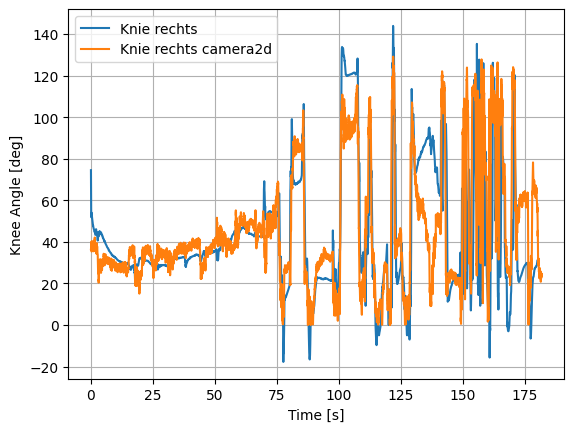

In [26]:
plt.plot(ts_resample, angle_kr_resample, label="Knie rechts") 
plt.plot(ts_camera2d, data_camera2d_kr, label="Knie rechts camera2d")
plt.grid()
plt.legend()
plt.ylabel("Knee Angle [deg]")
plt.xlabel("Time [s]")
plt.show()

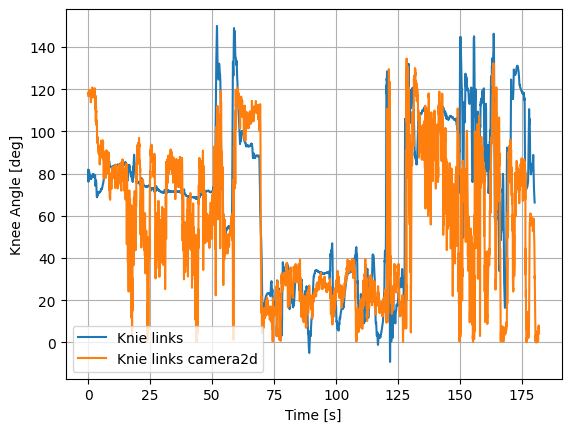

In [27]:
plt.plot(ts_resample, angle_kl_resample, label="Knie links")
plt.plot(ts_camera2d, data_camera2d_kl, label="Knie links camera2d")
plt.grid()
plt.legend()
plt.ylabel("Knee Angle [deg]")
plt.xlabel("Time [s]")
plt.show()

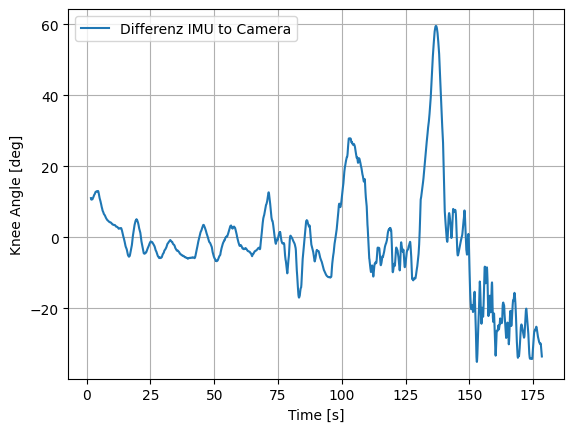

In [28]:
smoothed_arr = pd.Series(angle_kr_resample).rolling(window=100, center=True).mean().to_numpy()
smoothed_arr2 = pd.Series(data_camera2d_kr[:len(angle_kr_resample)]).rolling(window=100, center=True, min_periods=1).mean().to_numpy()
imu_to_camera2d_diff = smoothed_arr - smoothed_arr2
#for i in range(len(smoothed_arr)):
#    if smoothed_arr[i]<smoothed_arr2[i]:
#        imu_to_camera2d_diff[i] = smoothed_arr2[i] - smoothed_arr[i]

#imu_to_camera2d_diff = angle_kr_resample - data_camera2d_kr[:len(angle_kr_resample)]
#for i in range(len(angle_kr_resample)):
#    if angle_kr_resample[i] < data_camera2d_kr[:len(angle_kr_resample)][i]:
#        imu_to_camera2d_diff[i] = data_camera2d_kr[:len(angle_kr_resample)][i] - angle_kr_resample[i]
#smoothed_arr_itcd = pd.Series(imu_to_camera2d_diff).rolling(window=100, center=True).mean().to_numpy()

plt.plot(ts_resample, imu_to_camera2d_diff, label="Differenz IMU to Camera")
plt.grid()
plt.legend()
plt.ylabel("Knee Angle [deg]")
plt.xlabel("Time [s]")
plt.show()

In [29]:
rmse_value3 = np.sqrt(np.mean((angle_kr_resample - data_camera2d_kr[:len(angle_kr_resample)]) ** 2))
print(f"RMSE: {rmse_value3:.4f}")

RMSE: 22.8773


In [30]:

extras[1]["joint-center-to-body1"] = np.array([-0.5, 0.05, 0])         
extras[3]["joint-center-to-body1"] = np.array([0.05, 0.05, 0])         
extras[1]["joint-center-to-body2"] = np.array([0, -0.05, -0.025])      
extras[3]["joint-center-to-body2"] = np.array([0, -0.05, -0.025])      
extras[2]["joint-center-to-body1"] = np.array([0, 0.05, 0])             
extras[2]["joint-center-to-body2"] = np.array([0, -0.05, 0])            
extras[4]["joint-center-to-body1"] = np.array([0, 0.05, 0])             
extras[4]["joint-center-to-body2"] = np.array([0, -0.05, 0])            

In [ ]:
# SHOW ANIMATION
#T = int(10 / Ts)           # show only the first 10 seconds
#pos = np.zeros((T, 3))     # show only the first 10 seconds
pos = np.zeros((qhat[0].shape[0], 3))
pos[:, 2] = 0.05

#qhat_first_10_seconds = tree.map_structure(lambda a: a[:T], qhat)      # show only the first 10 seconds
vis_options = VisOptions(
    show_floor=False,
    show_stars=False,
    body_xyz_dim=0.03,
    imu_xyz_dim=0.02,
    imu_type="cylinder",
    imu_dim="0.01 0.005",
    imu_color="black",
    #floor_material="beige",
    joint_to_imu_color=[0.5, 0.5, 0.5, 1],
    imu_offset=[0, 0, -0.01],
    show_imu_xyz=False,
)
view(
    graph,
    qhat,
    extras,
    hz=100,
    show_every_nth_frame=4,
    global_translation=pos,
    height=720,
    width=1280,
    vis_options=vis_options,
)